**Purpose:** This notebook applies persistent homology, a technique from topology, to identify "loops" or cyclic patterns in wheat prices and build a simple trading strategy off of this property.

**Phase 1**: We gather the required data from Yahoo Finance, about 24 years worth of data

/tmp/ipython-input-1-3889879875.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1-3889879875.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price        Date  Crude_Oil   Wheat
Ticker                  CL=F    ZW=F
0      2000-08-23  32.049999  233.75
1      2000-08-24  31.629999  240.50
2      2000-08-25  32.049999  241.50
3      2000-08-28  32.869999  242.50
4      2000-08-29  32.720001  250.25


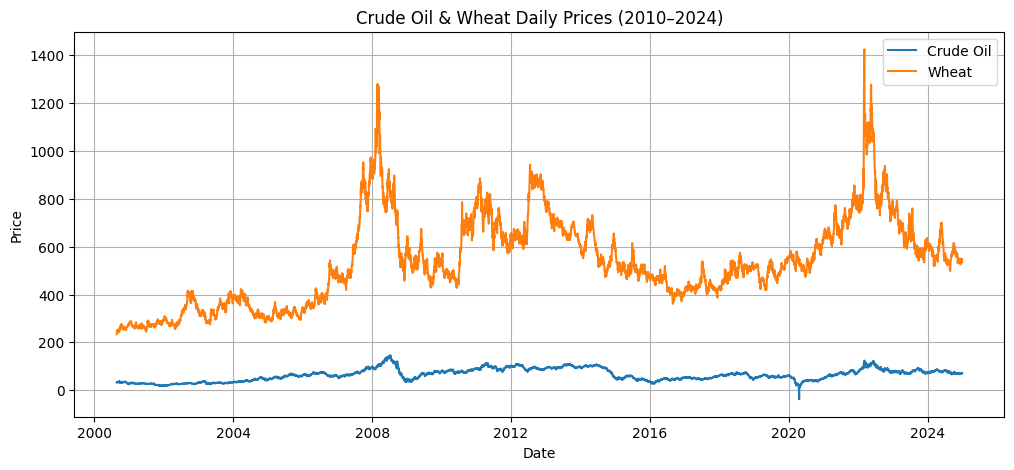

In [1]:
# 📦 Install dependencies (only needed if not already present)
!pip install yfinance --quiet

# 📈 Import packages
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 📅 Define parameters
tickers = {
    "Crude_Oil": "CL=F",  # WTI Crude Oil Futures
    "Wheat": "ZW=F"       # Wheat Futures
}
start_date = "2000-01-01"
end_date = "2024-12-31"

# 📥 Download daily closing prices
data = {}
for name, ticker in tickers.items():
    df = yf.download(ticker, start=start_date, end=end_date)
    df = df[['Close']].rename(columns={'Close': name})
    data[name] = df

# 🧹 Combine into single DataFrame
df_combined = pd.concat(data.values(), axis=1)
df_combined.dropna(inplace=True)

# 🪄 Reset index
df_combined = df_combined.reset_index()

# 📊 Preview
print(df_combined.head())

# 🖼️ Optional: Plot crude oil and wheat
plt.figure(figsize=(12, 5))
plt.plot(df_combined['Date'], df_combined['Crude_Oil'], label='Crude Oil')
plt.plot(df_combined['Date'], df_combined['Wheat'], label='Wheat')
plt.legend()
plt.title("Crude Oil & Wheat Daily Prices (2010–2024)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


**Phase 2:** We set up loops by creating 3D PCA vectors based on 20 day window sizes and 2 day step sizes

In [2]:
import numpy as np

# Set parameters for windowing
window_size_pca = 20  # e.g., 30–40 for crude, you can increase for wheat
step_size_pca = 2
asset = "Wheat"  # change to "Wheat" for wheat

# Extract just the series
series = df_combined[asset].values

# Make sure this gives (n_samples, window_size)
X = np.array([
    series[i:i+window_size_pca]
    for i in range(0, len(series) - window_size_pca, step_size_pca)
])

X = X.squeeze()  # Converts shape from (a, b, 1) → (a, b)
X_z = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)

# Optional: Reduce dimensionality (e.g., to 3D) via PCA
from sklearn.decomposition import PCA
X_3D = PCA(n_components=3).fit_transform(X)

# Preview
print("Shape of original point cloud:", X.shape)
print("Shape after PCA to 3D:", X_3D.shape)


Shape of original point cloud: (3032, 20)
Shape after PCA to 3D: (3032, 3)


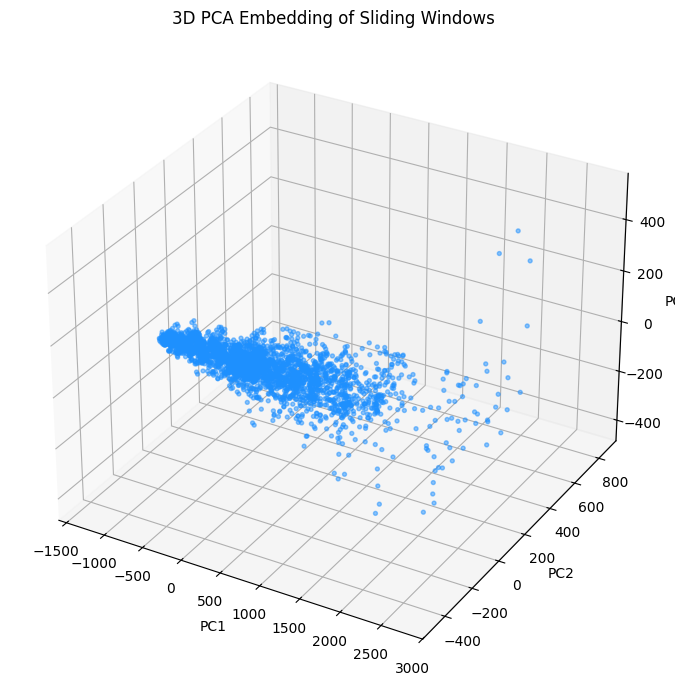

In [4]:
# 📦 Import 3D plotting tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 🎨 Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_3D[:, 0], X_3D[:, 1], X_3D[:, 2],
           c='dodgerblue', alpha=0.5, s=8)

# 🏷️ Axis labels
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Embedding of Sliding Windows")

plt.tight_layout()
plt.show()


In [5]:
# If df_combined.index is not already datetime
df_combined.index = pd.to_datetime(df_combined.index)

# Original date series
dates = df_combined.index.to_numpy()  # Assumes df_combined uses datetime index

# Center date of each window
date_centers = np.array([
    dates[i + window_size_pca // 2]
    for i in range(0, len(series) - window_size_pca, step_size_pca)
])


Text(0.5, 0.92, 'Color by Month')

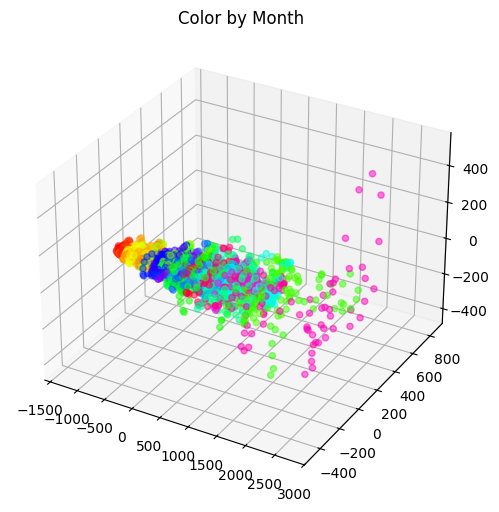

In [6]:
import matplotlib.pyplot as plt

# Suppose you stored timestamps for each window center in `dates`
import pandas as pd
import numpy as np

# Convert numpy.datetime64 to pandas.Timestamp to access .month
months = np.array([pd.Timestamp(d).month for d in date_centers])

colors = np.arange(len(date_centers))


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:, 0], X_3D[:, 1], X_3D[:, 2], c=colors, cmap='hsv', alpha=0.5)
ax.set_title("Color by Month")


**Observation:** Coloring by month shows that at least for some months the data seems to create ring like structures, indicating some promise in using persistent homology

**Phase 3**: Next we plor persistence diagrams on some subset of the data for Betti loops to see whether there are even loops that "survive" for long enough. Spoiler: We see that yes, this is indeed the case! And this gives us reason to do more serious modeling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.9 MB/s eta 0:00:00


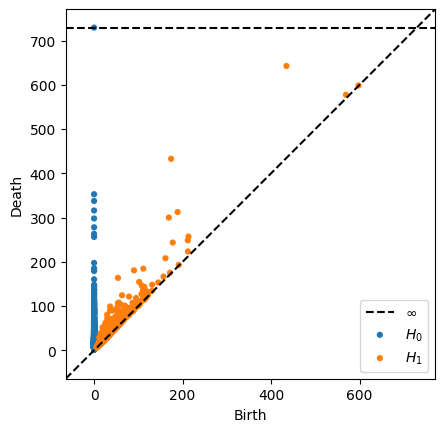

In [7]:
!pip install ripser --quiet
!pip install persim --quiet

# ⏩ Subsample to speed up
X_sample = X_3D[::1]  # Take every nth point (~1200 for n = 5 if you have ~6000)

# 📈 Compute persistent homology on the subsample
from ripser import ripser
from persim import plot_diagrams

result = ripser(X_sample, maxdim=1)
diagrams = result['dgms']

# 📊 Plot persistence barcodes
plot_diagrams(diagrams, show=True)


In [8]:
# Compute Betti-1 lifetimes
betti1 = diagrams[1]
lifetimes = betti1[:, 1] - betti1[:, 0]

print("Number of loops:", len(lifetimes))
print("Max lifetime:", np.max(lifetimes))
print("Mean lifetime:", np.mean(lifetimes))
print("Total Betti-1 persistence:", np.sum(lifetimes))


Number of loops: 1246
Max lifetime: 258.72540283203125
Mean lifetime: 6.895735172743208
Total Betti-1 persistence: 8592.086025238037


**Phase 4:** We now align the 3d vectors we created previously with dates and then collect these vectors to form "loop like" structures to see how loopy they truly are. This window size is conceptually different from that used to set up the 3D vectors!!

In [ ]:
# Align each X_3D vector to the center date of its window
price_indices = np.arange(len(series))
X_center_indices = np.array([
    i + window_size_pca // 2 for i in range(0, len(series) - window_size_pca, step_size_pca)
])


In [10]:
window_size_loop = 120
step_size_loop = 5
max_dim = 1  # Betti-1 (loops)


In [11]:
from ripser import ripser

threshold = 0  # You can tune this for visual clarity
loop_centers = []

for i in range(0, len(X_3D) - window_size_loop + 1, step_size_loop):
    window = X_3D[i:i + window_size_loop]
    result = ripser(window, maxdim=1)
    H1 = result['dgms'][1]

    if len(H1) > 0:
        lifetimes = H1[:, 1] - H1[:, 0]
        total_persistence = np.sum(lifetimes)

        if total_persistence > threshold:
            loop_center = i + window_size_loop // 2
            loop_centers.append(loop_center)


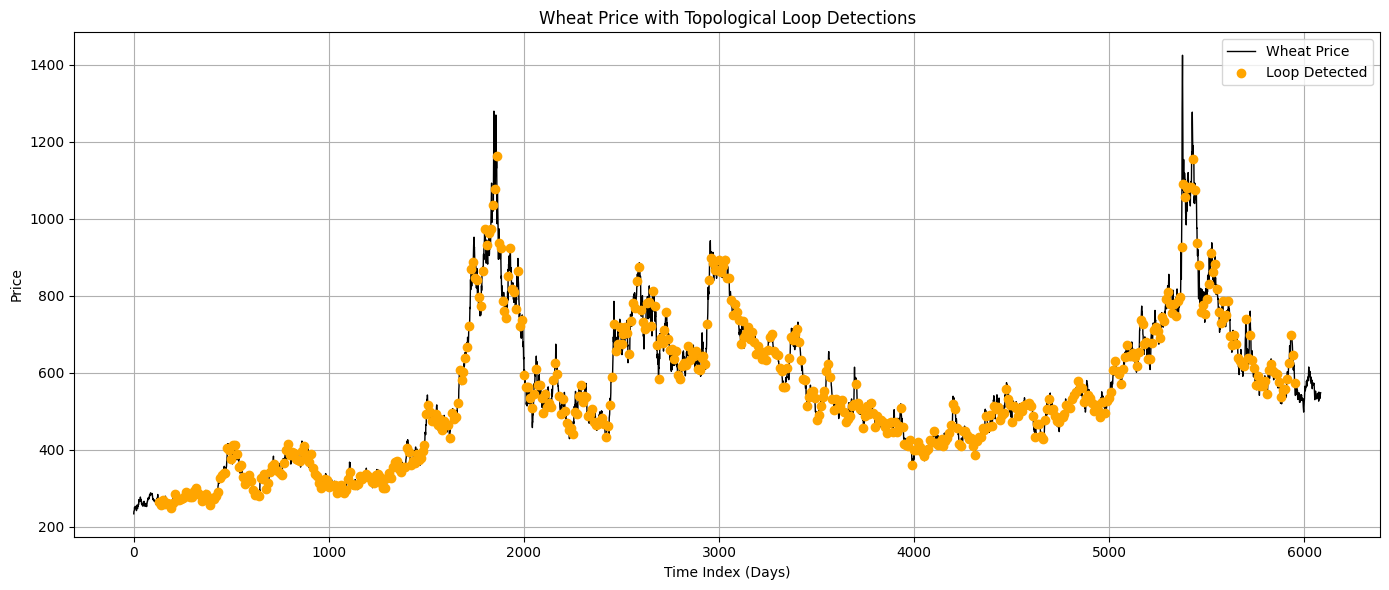

In [12]:
original_step = 2  # step used when building X i.e. PCA
adjusted_centers = [
    c * original_step + window_size_pca // 2
    for c in loop_centers
    if (c * original_step + window_size_pca // 2) < len(series)
]

plt.figure(figsize=(14, 6))
plt.plot(series, label="Wheat Price", color='black', linewidth=1)
plt.scatter(adjusted_centers, series[adjusted_centers], color='orange', label="Loop Detected", zorder=5)
plt.title("Wheat Price with Topological Loop Detections")
plt.xlabel("Time Index (Days)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The plot above just shows an overlay of longer-lived loops over the time series data

**Phase 5:** We now start storing these loopiness scores and identify a threshold for loopiness i.e. the median persistece value, and use a binary target variable that is 1 is loopiness exceds it and 0 otherwise

In [13]:
##Storing loop scores:
loopiness_scores = []
loop_centers = []

for i in range(0, len(X_3D) - window_size_loop + 1, step_size_loop):
    window = X_3D[i:i + window_size_loop]
    result = ripser(window, maxdim=1)
    H1 = result['dgms'][1]

    if len(H1) > 0:
        lifetimes = H1[:, 1] - H1[:, 0]
        total_persistence = np.sum(lifetimes)
    else:
        total_persistence = 0.0

    loopiness_scores.append(total_persistence)

    if total_persistence > threshold:  # Optional
        loop_center = i + window_size_loop // 2
        loop_centers.append(loop_center)



In [14]:
import numpy as np

# Convert Betti-1 persistence scores to binary labels
threshold = np.median(loopiness_scores)
labels = [1 if val > threshold else 0 for val in loopiness_scores]
labels = np.array(labels)

print(f"Label distribution: {np.bincount(labels)}")


Label distribution: [292 291]


**Phase 6:**We now run regressions of this binary target variable against standard values like mean price in the window, kurtosis, standard deviation etc. to see which factors are most predictive.

In [15]:
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf

window_starts = list(range(0, len(X_3D) - window_size_loop + 1, step_size_loop))

def extract_features_from_window(window):
    returns = np.diff(window)

    features = {
        "mean": np.mean(window),
        "std": np.std(window),
        "skew": skew(window),
        "kurtosis": kurtosis(window),
        "autocorr_1": acf(window, nlags=1, fft=False)[1],
        "return_autocorr_1": acf(returns, nlags=1, fft=False)[1] if len(returns) > 1 else 0.0
    }
    return list(features.values())

# Assemble full feature matrix
features = []

for i in window_starts:
    start = i * step_size_pca + window_size_pca // 2  # map X_3D index to series index
    window = series[start : start + window_size_loop].flatten()
    feat = extract_features_from_window(window)
    features.append(feat)

features = np.array(features)
print("Feature matrix shape:", features.shape)


Feature matrix shape: (583, 6)


In [16]:
print(len(loopiness_scores))

583


✅ Accuracy: 0.7692307692307693
✅ ROC AUC: 0.7705761316872428

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.48      0.49        27
           1       0.85      0.86      0.85        90

    accuracy                           0.77       117
   macro avg       0.67      0.67      0.67       117
weighted avg       0.77      0.77      0.77       117



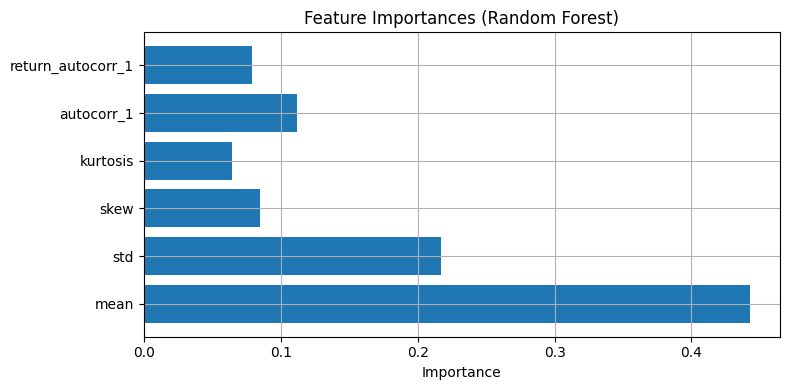

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Step 1: Train-test split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    features, labels, range(len(features)), test_size=0.2, shuffle=False, stratify=None
)

# Step 2: Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 3: Predict
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Step 4: Evaluate
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("✅ ROC AUC:", roc_auc_score(y_test, y_prob))
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))

# Step 5: Feature importances
feature_names = ["mean", "std", "skew", "kurtosis", "autocorr_1", "return_autocorr_1"]
importances = clf.feature_importances_

plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("Feature Importances (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()


**Observation:** We learn that mean contributes most here and the AUC is substantial at 0.77

**Phase 7:**Now based on our regression we create a simple strategy based on exit and entry thresholds to see whether the model has real value

In [18]:
wheat_series_flat = series.flatten()

In [19]:
initial_cash = 100000
position = 0  # 0 means no position, 1 means long
cash = initial_cash
portfolio_values = []


for i, idx in enumerate(window_starts):
    price = wheat_series_flat[idx]
    signal = labels[i]

    if signal == 1 and position == 0:
        # Enter long
        units = cash / price
        position = units
        cash = 0
    elif signal == 0 and position > 0:
        # Exit long
        cash = position * price
        position = 0

    # Portfolio value
    value = cash + (position * price if position > 0 else 0)
    portfolio_values.append(value)


In [33]:
adjusted_test_indices = [
    i * step_size_loop + window_size_loop // 2
    for i in idx_test
    if (i * step_size_loop + window_size_loop // 2) < len(series)
]

# 💰 Strategy variables
initial_cash = 100000
cash = initial_cash
position = 0.0
portfolio_values = []
entry_price = None
num_trades = 0

# 🏷 Align price series to X_test
price_series = wheat_series_flat[adjusted_test_indices]

# 🎯 Thresholds
enter_threshold = 0.52
exit_threshold = 0.48
stop_loss = -0.02
stop_gain = 0.10

for i in range(len(y_prob)):
    prob = y_prob[i]
    price = price_series[i]

    if prob > enter_threshold and position == 0:
        # Enter long position
        units = cash / price
        position = units
        cash = 0
        entry_price = price
        num_trades += 1

    elif position > 0:
        # Check for stop gain or stop loss
        pnl_pct = (price - entry_price) / entry_price
        if pnl_pct <= stop_loss or pnl_pct >= stop_gain or prob < exit_threshold:
            # Exit position
            cash = position * price
            position = 0
            entry_price = None

    # Compute current value
    value = cash + (position * price if position > 0 else 0)
    portfolio_values.append(value)

# 📊 Final stats
portfolio_values = np.array(portfolio_values)
days = len(portfolio_values)
initial_value = portfolio_values[0]
final_value = portfolio_values[-1]

returns = np.diff(portfolio_values) / portfolio_values[:-1]
years = days / 252
cagr = (final_value / initial_value) ** (1 / years) - 1
sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252)
downside_returns = returns[returns < 0]
sortino = np.mean(returns) / (np.std(downside_returns) + 1e-9) * np.sqrt(252)
running_max = np.maximum.accumulate(portfolio_values)
drawdown = (portfolio_values - running_max) / running_max
max_drawdown = drawdown.min()

# 📈 Print results
print(f"🔁 Number of Trades: {num_trades}")
print(f"📈 CAGR: {cagr:.2%}")
print(f"⚖️ Sharpe Ratio: {sharpe:.2f}")
print(f"📊 Sortino Ratio: {sortino:.2f}")
print(f"📉 Max Drawdown: {max_drawdown:.2%}")


🔁 Number of Trades: 29
📈 CAGR: 95.95%
⚖️ Sharpe Ratio: 1.34
📊 Sortino Ratio: 2.07
📉 Max Drawdown: -28.69%
